In [1]:
# Library
 
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.transforms import v2 as T

import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset

def Loader(cfg):
    trainT = T.Compose([
        T.Resize((cfg["img_size"], cfg["img_size"])),
        T.RandomHorizontalFlip(),
        #T.ColorJitter(0.4, 0.4, 0.4, 0.1),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    validT = T.Compose([
        T.Resize((cfg["img_size"], cfg["img_size"])),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10("./Datasets", train=True, transform=trainT, download=True),
        batch_size=cfg["batch_size"], shuffle=True)
    valid_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10("./Datasets", train=False, transform=validT, download=True),
        batch_size=cfg["batch_size"], shuffle=True)
    
    return train_loader, valid_loader

/home/aiuser/.conda/envs/taeuk/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 33, 33])
torch.Size([128, 9, 3, 11, 11])


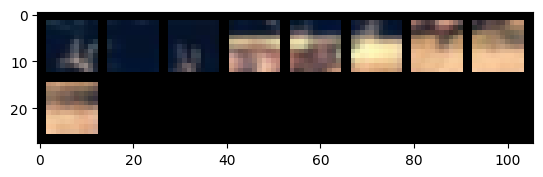

In [3]:
cfg = {
    "batch_size":128,
    "img_size":33,
    "grid":3,
    "num_layers":8,
    "num_classes":10,
    "num_epochs":50,
}
train_loader, valid_loader = Loader(cfg)

img, lab = next(iter(train_loader))
print(img.shape)

grid = 3
image = img.unsqueeze(2).view(-1, 3, grid, 33//grid, 33)
image = image.transpose(3,4)
image = image.reshape(-1, 3,9, 33//grid, 33//grid)
image = image.transpose(3,4).transpose(1,2)

plt.imshow(np.transpose(torchvision.utils.make_grid(image[3], normalize=True), (1,2,0)));

print(image.shape)

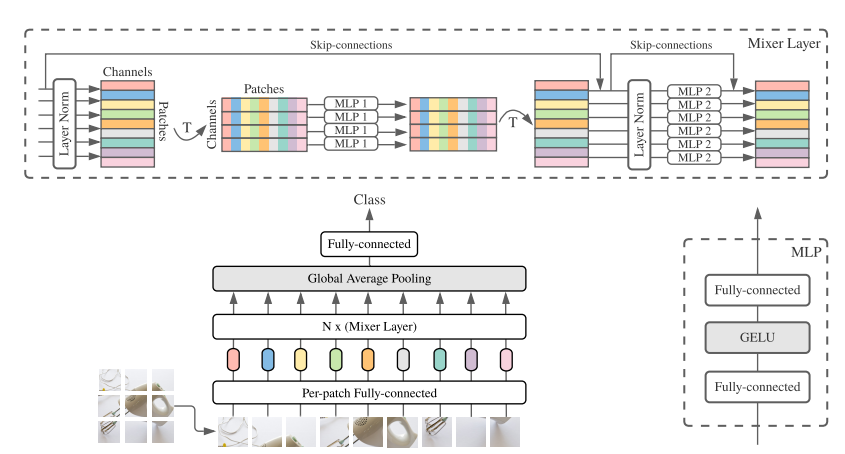

In [4]:
# Model

class PatchFlatten(nn.Module):
    def __init__(self, cfg):
        super(PatchFlatten, self).__init__()
        self.grid = cfg["grid"] # Sequence length S
        self.img_size = cfg["img_size"]
        
    def forward(self, image):
        image = image.unsqueeze(2).view(-1, 3, self.grid, self.img_size//self.grid, self.img_size)
        image = image.transpose(3,4)
        image = image.reshape(-1, 3, self.grid**2, 
                              self.img_size//self.grid, self.img_size//self.grid)
        image = image.transpose(3,4).transpose(1,2)
        image = image.reshape(image.size(0), self.grid**2, -1)
        return image # B, P, D
    
class MLP(nn.Module):
    def __init__(self, channels):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(channels, channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(channels, channels)
        
    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))
    
class MixerLayer(nn.Module):
    def __init__(self, cfg):
        super(MixerLayer, self).__init__()
        self.ln1 = nn.LayerNorm(cfg["grid"]**2, 3*(cfg["img_size"]//cfg["grid"])**2)
        self.mlp1 = MLP(cfg["grid"]**2)
        self.ln2 = nn.LayerNorm(cfg["grid"]**2, 3*(cfg["img_size"]//cfg["grid"])**2)
        self.mlp2 = MLP(3*(cfg["img_size"]//cfg["grid"])**2)
    
    def forward(self, x0):
        x = x0.transpose(1,2)
        x = self.ln1(x)
        x = x.transpose(1,2)

        x = x.transpose(1,2)
        x = self.mlp1(x)
        x = x.transpose(1,2)
        x0 = x + x0
        
        x = x0.transpose(1,2)
        x = self.ln2(x)
        x = x.transpose(1,2)
        
        x = self.mlp2(x)
        x = x + x0
        return x
        
class MLP_Mixer(nn.Module):
    def __init__(self, cfg):
        super(MLP_Mixer, self).__init__()
        self.patchs = PatchFlatten(cfg)
        self.layers = nn.Sequential(*[
            MixerLayer(cfg) for _ in range(cfg["num_layers"])
        ])
        self.avgpool = nn.AdaptiveAvgPool1d((1,))
        self.fc = nn.Linear(3*(cfg["img_size"]//cfg["grid"])**2, cfg["num_classes"])
    
    def forward(self, x):
        x = self.patchs(x)
        x = self.layers(x)
        x = x.transpose(1,2)
        x = self.avgpool(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

In [5]:
# training 

cfg = {
    "batch_size":512,
    "img_size":32,
    "grid":8,
    "num_layers":4,
    "num_classes":10,
    "num_epochs":100,
}
train_loader, valid_loader = Loader(cfg)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP_Mixer(cfg).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, betas=(0.9, 0.999))
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["num_epochs"]//3)

for epoch in tqdm(range(1, cfg["num_epochs"]+1)):
    train_loss = 0.
    valid_loss = 0.
    train_acc = 0.
    valid_acc = 0.
    
    model.train()
    for img, lab in train_loader:
        img, lab = img.to(device), lab.to(device)
        optimizer.zero_grad()
        logit = model(img)
        loss = F.cross_entropy(logit, lab)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _, pred = logit.max(dim=1)
            pred = pred.eq(lab).sum() / lab.size(0)    
            train_loss += loss.item()
            train_acc += pred.item()
            
    model.eval()    
    with torch.no_grad():
        for img, lab in valid_loader:
            img, lab = img.to(device), lab.to(device)
            logit = model(img)
            loss = F.cross_entropy(logit, lab) 
            _, pred = logit.max(dim=1)
            pred = pred.eq(lab).sum() / lab.size(0)  
            valid_loss += loss.item()
            valid_acc += pred.item()
            
    # scheduler.step()
    print(f"[Epoch {epoch:3d}] [Loss {train_loss/len(train_loader):.6f}  {valid_loss/len(valid_loader):.6f}] [Acc {train_acc/len(train_loader):.6f}  {valid_acc/len(valid_loader):.6f}]")


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch   1] [Loss 2.022895  1.854423] [Acc 0.258199  0.317027]
[Epoch   2] [Loss 1.771011  1.653388] [Acc 0.355698  0.394548]
[Epoch   3] [Loss 1.597829  1.534143] [Acc 0.417924  0.441952]
[Epoch   4] [Loss 1.492782  1.457345] [Acc 0.459682  0.474586]
[Epoch   5] [Loss 1.421898  1.383891] [Acc 0.491831  0.508680]
[Epoch   6] [Loss 1.367664  1.365753] [Acc 0.513111  0.509720]
[Epoch   7] [Loss 1.328723  1.321504] [Acc 0.528567  0.529504]
[Epoch   8] [Loss 1.292379  1.288952] [Acc 0.539973  0.538815]
[Epoch   9] [Loss 1.261410  1.274971] [Acc 0.552603  0.545812]
[Epoch  10] [Loss 1.235095  1.265965] [Acc 0.562176  0.553217]
[Epoch  11] [Loss 1.213614  1.224172] [Acc 0.569047  0.563591]
[Epoch  12] [Loss 1.190191  1.236854] [Acc 0.577748  0.560535]
[Epoch  13] [Loss 1.170002  1.217825] [Acc 0.585315  0.567325]
[Epoch  14] [Loss 1.150187  1.191530] [Acc 0.592796  0.575448]
[Epoch  15] [Loss 1.131438  1.181842] [Acc 0.601860  0.579389]
[Epoch  16] [Loss 1.111935  1.169290] [Acc 0.606192  0.